In [1]:
import torch
from matplotlib import pyplot as plt

from alfi.models import MultiOutputGP, generate_multioutput_rbf_gp
from alfi.configuration import VariationalConfiguration
from alfi.plot import Plotter1d

# from model import RNAVelocityLFM
from dataset import SingleCellKidney, Pancreas
from trainer import EMTrainer

import numpy as np

In [2]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
dataset = Pancreas()
print(dataset.m_observed.shape)
print(dataset.gene_names.shape)
print(dataset[0].shape)

torch.Size([1, 4000, 3696])
(2000,)
torch.Size([1, 3696])


In [3]:
def print_scatter(cells, gene_index, num_connections=10, colors=None):
    traj = trainer.previous_trajectory.mean.transpose(0, 1)
    u = traj[:2000].detach()  # (num_genes, 100, 1)
    s = traj[2000:].detach()  # (num_genes, 100, 1)
    u_y = cells[:2000]  # (num_genes, num_cells)
    s_y = cells[2000:]  # (num_genes, num_cells)

    plt.figure(figsize=(3, 3))
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], alpha=0.1,s=5, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, trainer.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, trainer.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [4]:
import torch
from torch.nn import Parameter
from torch.nn.functional import relu

from alfi.models import OrdinaryLFM
from alfi.configuration import VariationalConfiguration
from alfi.utilities.torch import softplus

class RNAVelocityLFM(OrdinaryLFM):
    def __init__(self, num_cells, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        num_genes = num_outputs // 2
        # self.transcription_rate = Parameter(3 * torch.rand(torch.Size([num_genes, 1]), dtype=torch.float64))
        self.splicing_rate = Parameter(1 * torch.rand(torch.Size([num_genes, 1]), dtype=torch.float64))
        self.decay_rate = Parameter(0.4 * torch.rand(torch.Size([num_genes, 1]), dtype=torch.float64))
        self.num_cells = num_cells
        ### Initialise random time assignments
        self.time_assignments = torch.rand(self.num_cells, requires_grad=False)

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        # if (self.nfe % 10) == 0:
        #     print(t)
        self.nfe += 1
        num_samples = h.shape[0]
        num_outputs = h.shape[1]
        h = h.view(num_samples, num_outputs//2, 2)
        u = h[:, :, 0].unsqueeze(-1)
        s = h[:, :, 1].unsqueeze(-1)

        f = self.f[:, :, self.t_index].unsqueeze(2)
        # print(torch.sum(s < 0), torch.sum(u < 0))
        du = f - self.splicing_rate * u
        ds = self.splicing_rate * u - self.decay_rate * s

        h_t = torch.cat([du, ds], dim=1)

        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        return h_t

    def nonlinearity(self, f):
        # return softplus(f)
        return relu(f)

    def mix(self, f):
        """
        Parameters:
            f: (I, T)
        """
        # nn linear
        return f.repeat(1, self.num_outputs//2//10, 1)  # (S, I, t)

    def predict_f(self, t_predict, **kwargs):
        # Sample from the latent distribution
        q_f = self.get_latents(t_predict.reshape(-1))
        f = q_f.sample([500])  # (S, I, t)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0]
        return torch.distributions.multivariate_normal.MultivariateNormal(f, scale_tril=q_f.scale_tril)

In [20]:
config = VariationalConfiguration(
    num_samples=20,
)
num_cells = dataset[0].shape[1]
num_latents = 10
num_inducing = 12  # (I x m x 1)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)

step_size = 1e-1

end_t = 12
inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       use_scale=False, initial_lengthscale=2,
                                       gp_kwargs=dict(natural=False))

Number of cells: 3696
Number of latent GPs (# transcription rates): 10


In [21]:
lfm = RNAVelocityLFM(num_cells, 4000, gp_model, config)

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.5)
trainer = EMTrainer(lfm, [optimizer], dataset, batch_size=4000)
plotter = Plotter1d(lfm, dataset.gene_names)

C:\Users\Jacob\Documents\proj\lafomo\alfi\models\variational_lfm.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


torch.Size([362, 10])
torch.Size([362, 10])
torch.Size([3, 10, 362])
torch.Size([4000, 3696, 1])


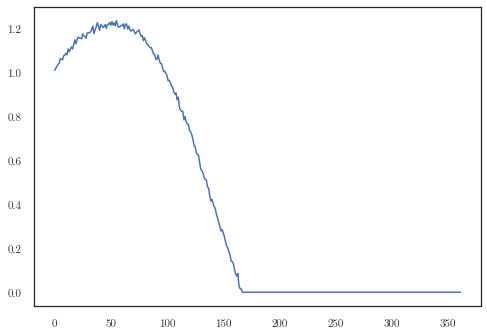

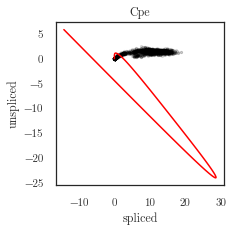

In [22]:
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
# print('feeding gp with ', t_f.shape)
q_f = gp_model(t_f)
print(q_f.mean.shape)
s = lfm.sample_latents(t_f)[0]
print(s.shape)
plt.plot(s[:, 0].detach())

print(q_f.rsample(torch.Size([3])).permute(0, 2, 1).shape)
cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print(cells.shape)
print_scatter(cells, cpe_index, num_connections=0)

tensor(False)
tensor(False)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

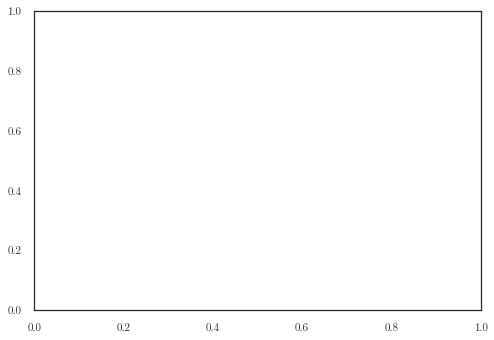

In [32]:
print(torch.isnan(lfm.splicing_rate).any())
print(torch.isnan(lfm.decay_rate).any())
mean = list(lfm.gp_model.variational_parameters())[0]
plt.plot(mean.detach())

In [24]:
import time
start = time.time()

output = trainer.train(1, report_interval=1, step_size=1e-1)
end = time.time()
print(end - start)

estep done
num t: torch.Size([27])
torch.Size([4000, 3696]) torch.Size([4000, 3696])
y targ torch.Size([3696, 4000])
torch.Size([4000, 3696]) torch.Size([4000, 3696])
covar torch.Size([4000, 3696, 3696])
torch.Size([4000, 3696]) MultivariateNormal(loc: torch.Size([4000, 3696]))
torch.Size([3696, 4000]) torch.Size([3696, 4000])
back
ward
Epoch 001/001 - Loss: 25641.71 (25641.71 0.00) kernel: [1.5841526 2.4452796 1.5841526 1.5841526 1.5841526 1.5841526 1.5841526
 2.4452794 2.4452796 1.5841526]
38.72318696975708


### Outputs prior to training:

In [9]:
trainer.previous_trajectory = lfm(trainer.timepoint_choices, step_size=step_size)

# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 2):
    print_scatter(cells, i)

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: For batch 0: U(4,4) is zero, singular U.

In [ ]:
u = trainer.previous_trajectory.mean[:, :2000].detach()
s = trainer.previous_trajectory.mean[:, 2000:].detach()
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])

In [ ]:
n
import scvelo as scv
scv.tl.velocity(dataset.loom)

In [ ]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [ ]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)

data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print(cells.shape)
print_scatter(cells, cpe_index, num_connections=0)



In [ ]:
lfm.gp_model.covar_module.lengthscale.shape

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)
data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)

In [ ]:
traj = trainer.previous_trajectory.mean.transpose(0, 1)
u = traj[:2000].detach()  # (num_genes, 100, 1)
s = traj[2000:].detach()  # (num_genes, 100, 1)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[:, :1000] - u.transpose(1, 2)
s_residual = s_y[:, :1000] - s.transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
# residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = 0
residual = residual[gene_index]
print(residual.shape)
residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort()
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=5, c='black')

for cell_index in residual_sort_indices[:100]:
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=8, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.8, c='purple')
# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)


In [ ]:
print(trainer.timepoint_choices[trainer.time_assignments_indices])
print(trainer.time_assignments_indices.shape)


In [ ]:
# plotter.plot_outputs(t_predict, replicate=0, ylim=(0, 3),
#                      t_scatter=t_observed, y_scatter=dataset.m_observed,
#                      model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-2, 4), plot_barenco=True, plot_inducing=False)
# plotter.plot_kinetics()
# plotter.plot_convergence(trainer)

In [ ]:
print(model.decay_rate)
print(model.transcription_rate)

In [ ]:
save(model, 'rnavelocity')

In [ ]:
do_load = False
if do_load:
    model = load('rnavelocity', RNAVelocityLFM, 2000, 1,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = EMTrainer(model, optimizer, dataset)
print(do_load)